# Skin Type Model
This model is the model that used to classify user's skin type and have an output of multi-class from 3 possible class (oily,normal,dry)

## Import Libraries, Mobilenet, and Env File

In [1]:
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds

In [2]:
# Importing Env File
from dotenv import load_dotenv
load_dotenv()
datasets_path = os.getenv('DATASET_PATH_TYPE')

In [3]:
# Importing MobileNetV2 Model With ImagNet Weight Without The Top Layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [30]:
# Membekukan semua lapisan dari model MobileNetV2
for layer in base_model.layers:
    layer.trainable = False

In [31]:
# Fine-tuning: Membuka beberapa lapisan terakhir dari MobileNetV2
for layer in base_model.layers[-25:]:  # Mengatur lebih banyak lapisan terakhir dapat dilatih
    layer.trainable = True


## Import Dataset

In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import os
from sklearn.model_selection import train_test_split

class SkinTypeDataset(tfds.core.GeneratorBasedBuilder):
    """DatasetBuilder for skin condition detection."""

    VERSION = tfds.core.Version('1.0.0')
    MANUAL_DOWNLOAD_INSTRUCTIONS = "Please ensure the skin type dataset is downloaded and located at the right path (look at env file)"

    def _info(self):
        return tfds.core.DatasetInfo(
            builder=self,
            description=("Dataset for skin type classification with 3 labels: oily, normal, dry"),
            features=tfds.features.FeaturesDict({
                'image': tfds.features.Image(shape=(224, 224, 3)),
                'label': tfds.features.Tensor(shape=(3,), dtype=tf.float32),
            }),
            supervised_keys=('image', 'label'),
        )

    def _split_generators(self, dl_manager):
        # Mengambil data dari path yang telah diinstruksikan
        path = dl_manager.manual_dir
        
        # Membaca semua gambar dan label
        all_data = []
        for category in ['oily', 'normal', 'dry']:
            category_path = os.path.join(path, category)
            for filename in os.listdir(category_path):
                all_data.append((filename, category))

        # Membuat DataFrame
        df = pd.DataFrame(all_data, columns=['filename', 'label'])

        # Menyeimbangkan dataset dengan mengambil 500 sampel dari setiap kelas
        balanced_df = df.groupby('label').apply(lambda x: x.sample(n=500, random_state=42)).reset_index(drop=True)

        # Membagi data menjadi train, val, dan test
        train_df, test_df = train_test_split(balanced_df, test_size=0.2, random_state=42)
        train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  # 0.25 dari train untuk validasi

        return {
            'train': self._generate_examples(train_df, path),
            'val': self._generate_examples(val_df, path),
            'test': self._generate_examples(test_df, path),
        }

    def _generate_examples(self, dataframe, base_path):
        """Yields examples."""
        label_map = {
            'oily': [1, 0, 0],
            'normal': [0, 1, 0],
            'dry': [0, 0, 1],
        }
        for _, row in dataframe.iterrows():
            image_path = os.path.join(base_path, row['label'], row['filename'])
            unique_key = f"{row['label']}_{row['filename']}"  # Unique Key To Avoid Duplicates
            print(f"Accessing: {image_path}")  # Debugging print statement
            label = label_map[row['label']]
            yield unique_key, {  # Using Unique Key
                'image': image_path,
                'label': label,
            }


builder = SkinTypeDataset(data_dir=datasets_path)
builder.download_and_prepare()

# Memuat dataset
ds_train = builder.as_dataset(split='train')
ds_val = builder.as_dataset(split='val')
ds_test = builder.as_dataset(split='test')


In [11]:
# Memuat dataset yang sudah diproses
ds_train = tfds.load('skin_type_dataset', split='train', data_dir=datasets_path)
ds_val = tfds.load('skin_type_dataset', split='val', data_dir=datasets_path)
ds_test = tfds.load('skin_type_dataset', split='test', data_dir=datasets_path)

In [12]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Fungsi untuk memastikan data tersusun sebagai pasangan (image, label)
def preprocess(data):
    image = data['image']
    label = data['label']
    return image, label

def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = preprocess_input(image)  # Preprocessing sesuai MobileNet
    return image, label

ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

ds_train = ds_train.map(preprocess_image)
ds_val = ds_val.map(preprocess_image)
ds_test = ds_test.map(preprocess_image)

ds_train = ds_train.batch(32).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.batch(32).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.batch(32).prefetch(tf.data.AUTOTUNE)

In [32]:
from tensorflow.keras.layers import Dropout, BatchNormalization, GlobalAveragePooling2D, Dense, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Menambahkan lapisan kustom di atas MobileNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x) 
# x = Dense(1024, kernel_regularizer=l2(0.01))(x)
# x = BatchNormalization()(x)
# x = ReLU()(x)  # ReLU activation setelah batch normalization
# x = Dropout(0.4)(x) 
x = Dense(512, kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = ReLU()(x)  # ReLU activation setelah batch normalization
x = Dropout(0.3)(x)
outputs = Dense(3, activation='softmax', kernel_regularizer=l2(0.01))(x)  # Menggunakan softmax untuk multi-class classification

# Membuat model akhir
model = Model(inputs=base_model.input, outputs=outputs)


# Menyesuaikan optimizer dan learning rate 
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9) 
# Compiling the model 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, patience=5, 
    min_lr=0.001)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=6,          
    restore_best_weights=True
)

In [15]:
for image, label in ds_train.take(1):
    print(image.shape, label.shape)  # Pastikan gambar memiliki shape (32, 224, 224, 3)

(32, 224, 224, 3) (32, 3)


In [ ]:
# # Fungsi untuk augmentasi data
# def augment(image, label):
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_flip_up_down(image)
#     image = tf.image.random_brightness(image, max_delta=0.3)
#     image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
#     return image, label

# # Menyiapkan dataset dengan augmentasi
# ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# ds_train = ds_train.map(lambda image, label: augment(image, label), num_parallel_calls=tf.data.experimental.AUTOTUNE)
# ds_train = ds_train.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

# ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# ds_val = ds_val.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

# ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# ds_test = ds_test.batch(32).prefetch(tf.data.experimental.AUTOTUNE)


Epoch 1/20


36/36 ━━━━━━━━━━━━━━━━━━━━ 18s 401ms/step - accuracy: 0.5992 - loss: 8.1008 - val_accuracy: 0.4136 - val_loss: 8.8489 - learning_rate: 0.0010
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 365ms/step - accuracy: 0.9908 - loss: 7.2965 - val_accuracy: 0.4267 - val_loss: 8.7838 - learning_rate: 0.0010
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 375ms/step - accuracy: 0.9977 - loss: 7.1784 - val_accuracy: 0.4686 - val_loss: 8.6007 - learning_rate: 0.0010
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.9991 - loss: 7.0714 - val_accuracy: 0.4974 - val_loss: 8.4817 - learning_rate: 0.0010
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 1.0000 - loss: 6.9670 - val_accuracy: 0.5052 - val_loss: 8.3911 - learning_rate: 0.0010
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 369ms/step - accuracy: 1.0000 - loss: 6.8665 - val_accuracy: 0.5340 - val_loss: 8.2903 - learning_rate: 0.0010
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 361ms/step - accuracy: 1.0000 - loss: 6.7674 - val_

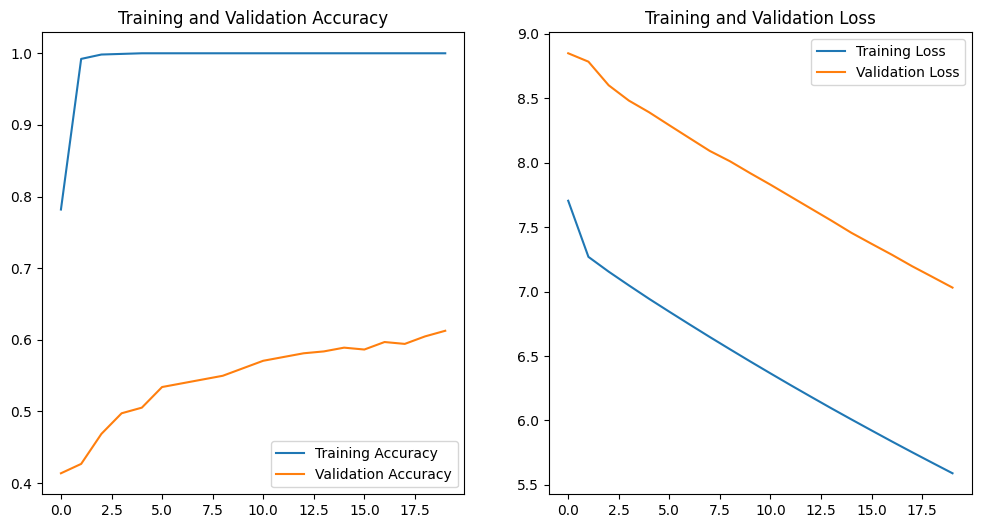

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.5453 - loss: 7.1481
Testing Loss: 7.166433811187744, Testing Accuracy: 0.5523560047149658


In [33]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

class_weight = {0: 1.5, 1: 0.4, 2: 1.5}  # Sesuaikan bobot berdasarkan kinerja kelas

# Melatih model dan mencatat hasil pelatihan dalam objek `history`
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=20,
    class_weight=class_weight,
    callbacks=[early_stopping, reduce_lr]
)

# Menampilkan metrik dengan matplotlib
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(accuracy))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluasi model pada data testing
loss, accuracy = model.evaluate(ds_test)
print(f'Testing Loss: {loss}, Testing Accuracy: {accuracy}')


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 297ms/step


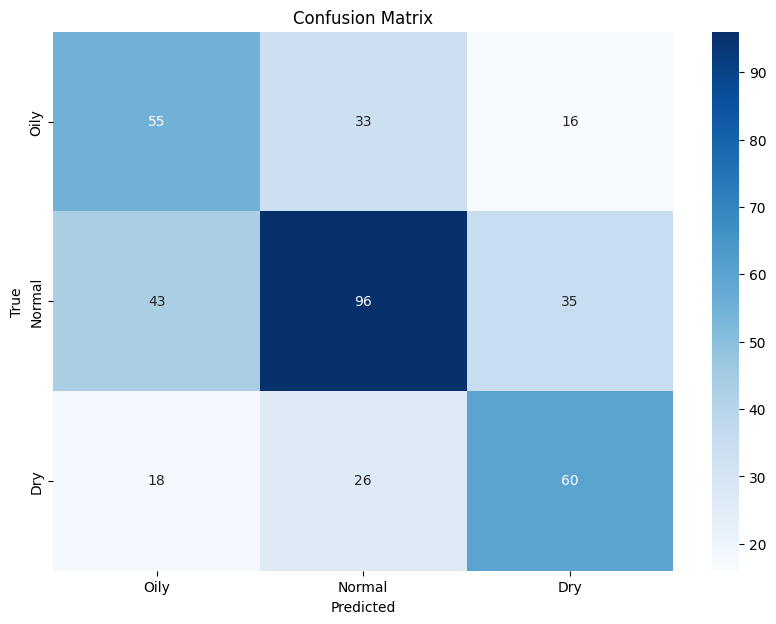

              precision    recall  f1-score   support

        Oily       0.47      0.53      0.50       104
      Normal       0.62      0.55      0.58       174
         Dry       0.54      0.58      0.56       104

    accuracy                           0.55       382
   macro avg       0.54      0.55      0.55       382
weighted avg       0.56      0.55      0.55       382



In [34]:
# Membuat prediksi pada data testing
y_pred = model.predict(ds_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Mendapatkan label aktual
y_true = np.concatenate([y for x, y in ds_test], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

# Menghitung confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Menampilkan confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Oily', 'Normal', 'Dry'], yticklabels=['Oily', 'Normal', 'Dry'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Menampilkan laporan klasifikasi
print(classification_report(y_true_classes, y_pred_classes, target_names=['Oily', 'Normal', 'Dry']))
